In [1]:
%matplotlib inline

# IMPORTAÇÃO DAS BIBLIOTECAS E CONFIGURAÇÃO
print("Importando bibliotecas...")

import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from google.colab.patches import cv2_imshow

print("Bibliotecas importadas com sucesso!")

Importando bibliotecas...
Bibliotecas importadas com sucesso!


In [2]:
# CARREGAMENTO E PREPARAÇÃO DO DATASET (LFW)
print("\nPASSO 1: Carregando e preparando o dataset 'Labeled Faces in the Wild'...")

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=1.0)

X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
n_samples, h, w = X.shape

print(f"\nDataset carregado com sucesso!")
print(f" - Dimensões de cada imagem: {h}x{w} pixels")

# CORREÇÃO DE SEGURANÇA
# Apenas normaliza os dados se o valor máximo for maior que 1.
# Isso impede o erro de "dupla normalização" se a célula for executada mais de uma vez.
if X.max() > 1.0:
    print("Normalizando dados dos pixels...")
    X = X / 255.0
else:
    print("Dados dos pixels já estão normalizados.")

X = np.stack([X]*3, axis=-1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Dados divididos e prontos para o treinamento.")


PASSO 1: Carregando e preparando o dataset 'Labeled Faces in the Wild'...

Dataset carregado com sucesso!
 - Dimensões de cada imagem: 125x94 pixels
Dados dos pixels já estão normalizados.
Dados divididos e prontos para o treinamento.


In [3]:
# CONSTRUÇÃO DO MODELO DE RECONHECIMENTO (TRANSFER LEARNING)
print("\nConstruindo o modelo de reconhecimento com Transfer Learning.")

input_shape = (h, w, 3)

# Carregando o modelo base sem a camada de classificação final
base_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

# Congelando os pesos do modelo base para não retreiná-los
base_model.trainable = False

# Criando o novo modelo em cima do modelo base
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

# Compilando o modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()
print("Modelo construído com sucesso!")


Construindo o modelo de reconhecimento com Transfer Learning.


/tmp/ipython-input-3638714716.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 4, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Modelo construído com sucesso!


In [4]:
# TREINAMENTO DO MODELO
print("\nIniciando o treinamento do modelo:")

history = model.fit(
    X_train,
    y_train,
    epochs=15,
    validation_data=(X_test, y_test)
)

print("Treinamento concluído!")


Iniciando o treinamento do modelo:
Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 459ms/step - accuracy: 0.2717 - loss: 2.4422 - val_accuracy: 0.5994 - val_loss: 1.2688
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 385ms/step - accuracy: 0.5822 - loss: 1.2469 - val_accuracy: 0.6770 - val_loss: 0.9629
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - accuracy: 0.6432 - loss: 1.0311 - val_accuracy: 0.7143 - val_loss: 0.8351
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - accuracy: 0.6600 - loss: 0.9206 - val_accuracy: 0.7174 - val_loss: 0.8144
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 390ms/step - accuracy: 0.7505 - loss: 0.7220 - val_accuracy: 0.7547 - val_loss: 0.7105
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.7894 - loss: 0.6608 - val_accuracy: 0.7981 - val_loss: 0.6540
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 333ms/step - accuracy: 0.8089 - loss: 0.5918 - val_accuracy: 0.7733 - val_loss: 0.6482
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accura


PASSO 4: Avaliando a performance do modelo no conjunto de teste...

Acurácia no conjunto de teste: 82.92%
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 379ms/step

Relatório de Classificação:
                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.79      0.83        19
     Colin Powell       0.79      0.90      0.84        59
  Donald Rumsfeld       0.88      0.70      0.78        30
    George W Bush       0.83      0.96      0.89       133
Gerhard Schroeder       0.76      0.48      0.59        27
      Hugo Chavez       1.00      0.50      0.67        18
       Tony Blair       0.82      0.78      0.80        36

         accuracy                           0.83       322
        macro avg       0.85      0.73      0.77       322
     weighted avg       0.83      0.83      0.82       322


Matriz de Confusão:


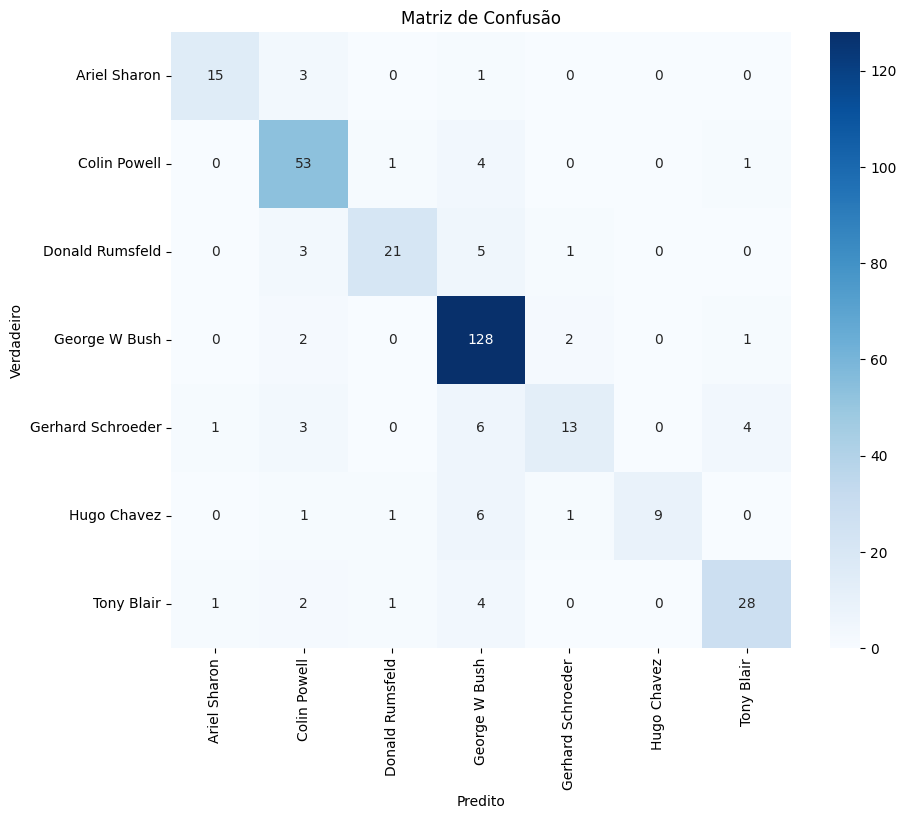

In [5]:
# AVALIAÇÃO DA PERFORMANCE DO MODELO
print("\nPASSO 4: Avaliando a performance do modelo no conjunto de teste...")

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nAcurácia no conjunto de teste: {accuracy * 100:.2f}%")

# Gerando predições para gerar o relatório
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_classes, target_names=target_names))

# Matriz de Confusão
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()


Testando o pipeline completo...
Procurando uma imagem no conjunto de teste onde a detecção de rosto funcione...

Tentativa 1: Analisando imagem de 'Colin Powell'...


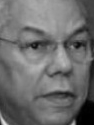


Tentativa 2: Analisando imagem de 'Colin Powell'...


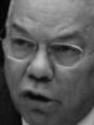


Tentativa 3: Analisando imagem de 'George W Bush'...


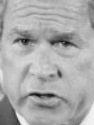


Sucesso! Rosto detectado na imagem de 'George W Bush'.

Exibindo resultado da detecção e reconhecimento:


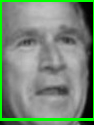



Projeto Finalizado!


In [6]:
# TESTE FINAL - APLICANDO O PIPELINE (DETECÇÃO + RECONHECIMENTO)
print("\nTestando o pipeline completo...")
print("Procurando uma imagem no conjunto de teste onde a detecção de rosto funcione...")

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

rosto_encontrado_e_exibido = False

# Loop para procurar uma imagem válida
for i in range(len(X_test)):
    original_image = (X_test[i] * 255).astype(np.uint8)
    true_label = target_names[y_test[i]]

    if i < 3:
        print(f"\nTentativa {i+1}: Analisando imagem de '{true_label}'...")
        cv2_imshow(cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR))

    image_bgr = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)
    gray_image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=4)

    if len(faces) > 0:
        print(f"\nSucesso! Rosto detectado na imagem de '{true_label}'.")

        (x, y, w, h) = faces[0]

        # Adicionando uma margem (padding) ao retângulo
        # Adicionar 20% da largura/altura como margem para cada lado
        padding_h = int(0.35 * h)
        padding_w = int(0.2 * w)

        # Calculando as novas coordenadas, garantindo que não saiam dos limites da imagem
        x1 = max(0, x - padding_w)
        y1 = max(0, y - padding_h)
        x2 = min(image_bgr.shape[1], x + w + padding_w)
        y2 = min(image_bgr.shape[0], y + h + padding_h)
        # Fim do ajuste

        face_roi_rgb = original_image[y:y+h, x:x+w]
        resized_face = cv2.resize(face_roi_rgb, (w, h))
        input_face = np.expand_dims(resized_face, axis=0) / 255.0

        prediction = model.predict(input_face, verbose=0)
        predicted_class_index = np.argmax(prediction)
        confidence = np.max(prediction)
        predicted_person_name = target_names[predicted_class_index]

        color = (0, 255, 0) # Verde

        # Desenhando o novo retângulo expandido
        cv2.rectangle(image_bgr, (x1, y1), (x2, y2), color, 2)

        # Escrevendo o texto na nova posição
        text = f"{predicted_person_name} ({confidence:.2f})"
        cv2.putText(image_bgr, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        print("\nExibindo resultado da detecção e reconhecimento:")
        cv2_imshow(image_bgr)

        rosto_encontrado_e_exibido = True
        break

if not rosto_encontrado_e_exibido:
    print("\n[FALHA] Não foi possível detectar um rosto em nenhuma das imagens do conjunto de teste, mesmo com parâmetros ajustados.")

print("\n\nProjeto Finalizado!")


Usando um detector de faces moderno (Deep Learning)...
Novo detector baixado com sucesso.
Detector Deep Learning carregado.
Analisando rostos com o novo detector...

Exibindo resultado final com o detector profissional:


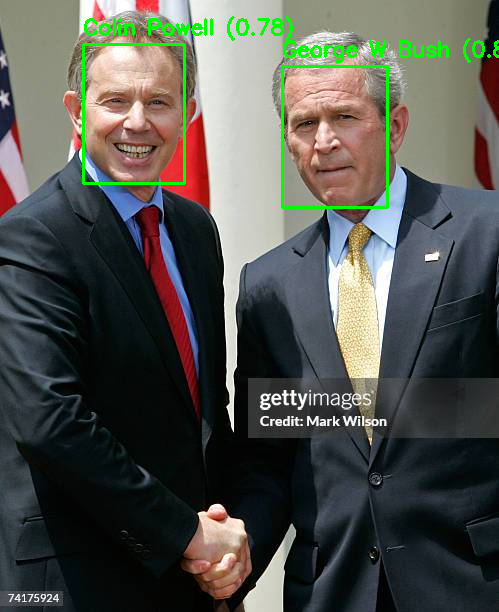



Projeto Finalizado!


In [7]:
# UPGRADE PARA UM DETECTOR DEEP LEARNING (DNN)
import cv2
import os
import requests

print("\nUsando um detector de faces moderno (Deep Learning)...")

# 1: Baixar os arquivos do novo modelo de detecção
# Arquivo de definição do modelo (prototxt) e pesos pré-treinados (caffemodel)
prototxt_url = 'https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt'
model_url = 'https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel'

prototxt_path = 'deploy.prototxt'
model_path = 'res10_300x300_ssd_iter_140000.caffemodel'

if not os.path.exists(prototxt_path):
    print("Baixando o arquivo prototxt...")
    r = requests.get(prototxt_url)
    with open(prototxt_path, 'wb') as f:
        f.write(r.content)

if not os.path.exists(model_path):
    print("Baixando o arquivo caffemodel...")
    r = requests.get(model_url)
    with open(model_path, 'wb') as f:
        f.write(r.content)

print("Novo detector baixado com sucesso.")

# 2: Carregar o novo modelo de detecção
net = cv2.dnn.readNetFromCaffe(prototxt_path, model_path)
print("Detector Deep Learning carregado.")

# 3: Executar o pipeline com o novo detector
image_path = 'Teste.jpg'

if os.path.exists(image_path):
    image_to_test = cv2.imread(image_path)
    (h_img, w_img) = image_to_test.shape[:2]

    # Pré-processamento da imagem para o novo detector
    blob = cv2.dnn.blobFromImage(cv2.resize(image_to_test, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

    # Passa a imagem pela rede para obter as detecções
    net.setInput(blob)
    detections = net.forward()

    print(f"Analisando rostos com o novo detector...")

    # Loop sobre as detecções
    for i in range(0, detections.shape[2]):
        # Extrai a confiança (probabilidade) da detecção
        confidence = detections[0, 0, i, 2]

        # Filtra detecções fracas, garantindo que seja um rosto de verdade
        if confidence > 0.5: # A confiança do DETECTOR deve ser > 50%

            # Calcula as coordenadas (x, y) do retângulo do rosto
            box = detections[0, 0, i, 3:7] * np.array([w_img, h_img, w_img, h_img])
            (startX, startY, endX, endY) = box.astype("int")

            # Garante que as coordenadas não saiam da imagem
            (x, y) = (max(0, startX), max(0, startY))
            w = endX - x
            h = endY - y

            # Agora que encontrou um rosto detectado com alta confiança, é usado o RECONHECEDOR
            face_roi_rgb = cv2.cvtColor(image_to_test[y:y+h, x:x+w], cv2.COLOR_BGR2RGB)

            h_train, w_train = 125, 94
            resized_face = cv2.resize(face_roi_rgb, (w_train, h_train))
            input_face = np.expand_dims(resized_face, axis=0) / 255.0

            prediction = model.predict(input_face, verbose=0)
            predicted_class_index = np.argmax(prediction)
            rec_confidence = np.max(prediction)

            # Usando o filtro de confiança de 80% para o RECONHECIMENTO
            rec_threshold = 0.5
            if rec_confidence > rec_threshold:
                predicted_person_name = target_names[predicted_class_index]
            else:
                predicted_person_name = "Desconhecido"

            color = (0, 255, 0) if predicted_person_name != "Desconhecido" else (0, 0, 255)
            # Desenhando o retângulo
            cv2.rectangle(image_to_test, (x, y), (x + w, y + h), color, 2)
            text = f"{predicted_person_name} ({rec_confidence:.2f})"
            cv2.putText(image_to_test, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    print("\nExibindo resultado final com o detector profissional:")
    cv2_imshow(image_to_test)
else:
    print(f"ERRO: O arquivo '{image_path}' não foi encontrado.")

print("\n\nProjeto Finalizado!")

# Obs.: O algorítmo está trocando o Tony Blair pelo Colin Powell possivelmente pela falta
# de fotos na base de dados, o que faz com o treinamento não seja eficiente para reconhece-lo
# da forma correta. Entretanto, apesar do erro, o algorítmo demonstrou eficácia no
# reconhecimento facial!